<a href="https://colab.research.google.com/github/khan1r/python_codes/blob/master/eco_fri_nn_finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive to access dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Set Constants and Dataset Path**

In [4]:
# ======================== Load Data ========================
# Define the dataset directory (adjust this path based on your Kaggle file system)
dataset_dir = '/content/drive/MyDrive/Datasets/dataset-resized'  # Update this based on dataset structure

# **Define Data Loading Function**

In [5]:
# Load file paths and their labels, shuffle the list to randomize data access
files = glob.glob(dataset_dir + "/*/*")
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns=["Image", "Label"])

In [6]:
# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

Dataset Sample:
                                               Image      Label
0  /content/drive/MyDrive/Datasets/dataset-resize...      paper
1  /content/drive/MyDrive/Datasets/dataset-resize...  cardboard
2  /content/drive/MyDrive/Datasets/dataset-resize...      glass
3  /content/drive/MyDrive/Datasets/dataset-resize...      paper
4  /content/drive/MyDrive/Datasets/dataset-resize...    plastic


In [7]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

In [8]:
# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


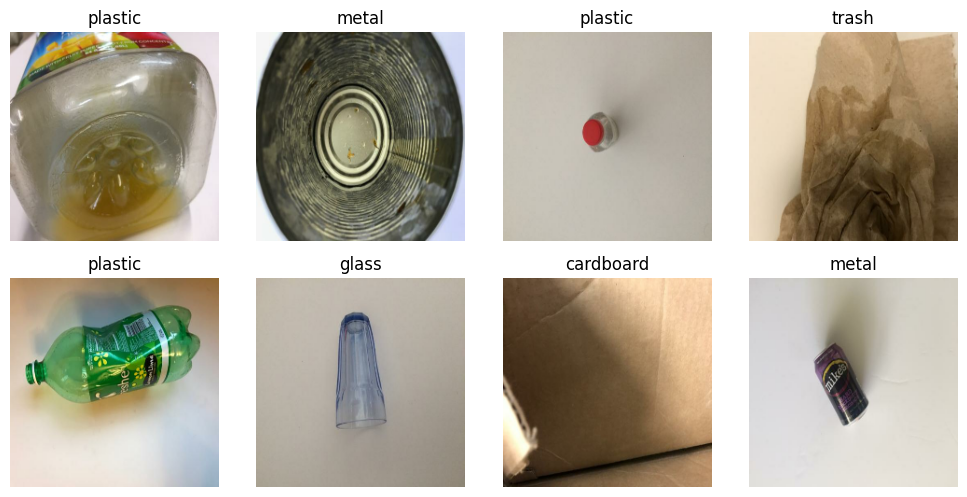

In [9]:
# ======================== Display Sample Images ========================
# Visualizing some of the training images with their labels
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300)  # Save in high definition

In [10]:
# ======================== Build the Eco_Fri_NN Model ========================
# Building a model using EfficientNetV2B1 base
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
eco_fri_nn = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

In [11]:
# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_eco_fri_nn_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
eco_fri_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_eco_fri_nn = eco_fri_nn.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3762 - loss: 3.8741 - val_accuracy: 0.8693 - val_loss: 2.8025
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7894 - loss: 2.7393 - val_accuracy: 0.9129 - val_loss: 2.5208
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.8463 - loss: 2.5570 - val_accuracy: 0.9208 - val_loss: 2.3750
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.8809 - loss: 2.4256 - val_accuracy: 0.9426 - val_loss: 2.2720
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8955 - loss: 2.3182 - val_accuracy: 0.9584 - val_loss: 2.1680
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9041 - loss: 2.2486 - val_accuracy: 0.9743 - val_loss: 2.0870
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9220 - loss: 2.1781 - val_accuracy: 0.9723 - val_loss: 2.0180
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9333 - loss: 2.0957 - val_accuracy: 0.98

In [12]:
# Load base model
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

eco_fri_nn = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_eco_fri_nn_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
eco_fri_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_eco_fri_nn = eco_fri_nn.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4031 - loss: 3.7466 - val_accuracy: 0.8515 - val_loss: 2.8014
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.7845 - loss: 2.7271 - val_accuracy: 0.9267 - val_loss: 2.4790
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.8674 - loss: 2.4892 - val_accuracy: 0.9485 - val_loss: 2.3191
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.8926 - loss: 2.3682 - val_accuracy: 0.9545 - val_loss: 2.2143
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9372 - loss: 2.2158 - val_accuracy: 0.9663 - val_loss: 2.1075
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9468 - loss: 2.1342 - val_accuracy: 0.9782 - val_loss: 2.0146
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9593 - loss: 2.0387 - val_accuracy: 0.9842 - val_loss: 1.9420
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9703 - loss: 1.9685 - val_accuracy: 0.98

In [13]:
# Model Architecture
eco_fri_nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,191,688 (57.95 MB)

 Trainable params: 3,139,430 (11.98 MB)

 Non-trainable params: 5,773,396 (22.02 MB)

 Optimizer params: 6,278,862 (23.95 MB)

In [14]:
# Save Training History
hist_eco_fri_nn_df = pd.DataFrame(hist_eco_fri_nn.history)
print("Training History:")
print(hist_eco_fri_nn_df)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.570722  3.326604      0.851485  2.801359
1   0.813551  2.657412      0.926733  2.479008
2   0.877349  2.453629      0.948515  2.319137
3   0.906528  2.335262      0.954455  2.214325
4   0.937685  2.204282      0.966337  2.107513
5   0.946093  2.122706      0.978218  2.014618
6   0.958457  2.032139      0.984158  1.941962
7   0.968843  1.951253      0.986139  1.886106
8   0.975767  1.869196      0.986139  1.818896
9   0.982196  1.787678      0.982178  1.768410
10  0.984174  1.724484      0.984158  1.710902
11  0.981207  1.666478      0.976238  1.642970
12  0.983680  1.594172      0.988119  1.567322
13  0.985163  1.535427      0.990099  1.497453
14  0.984669  1.471575      0.986139  1.452157
15  0.990109  1.404491      0.984158  1.386629
16  0.986647  1.352439      0.984158  1.350851
17  0.985658  1.305650      0.988119  1.276405
18  0.989614  1.237272      0.982178  1.233406
19  0.984174  1.199833      0.982178  1.18

In [15]:
# ======================== Evaluate Proposed Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = eco_fri_nn.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 679ms/step
Predictions vs Actual Labels:
     Actual  Prediction
0         4           4
1         0           0
2         0           0
3         4           4
4         3           3
..      ...         ...
500       1           1
501       0           0
502       3           3
503       4           4
504       0           0

[505 rows x 2 columns]


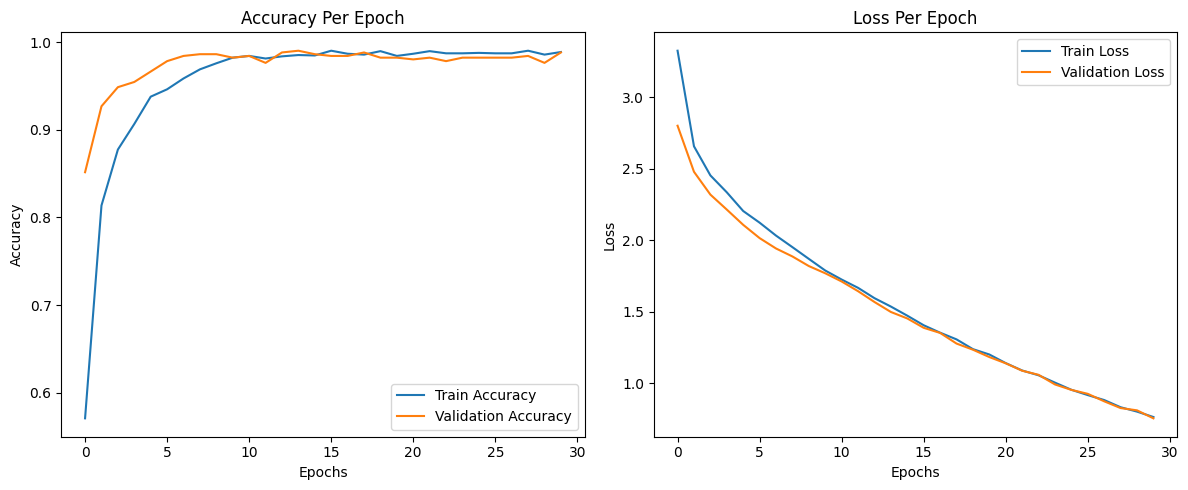

In [16]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_eco_fri_nn_df['accuracy'], label='Train Accuracy')
plt.plot(hist_eco_fri_nn_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Per Epoch')

plt.subplot(1, 2, 2)
plt.plot(hist_eco_fri_nn_df['loss'], label='Train Loss')
plt.plot(hist_eco_fri_nn_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Per Epoch')

plt.tight_layout()
plt.savefig('accuracy_loss_per_epoch.png', dpi=300)  # Save in high definition

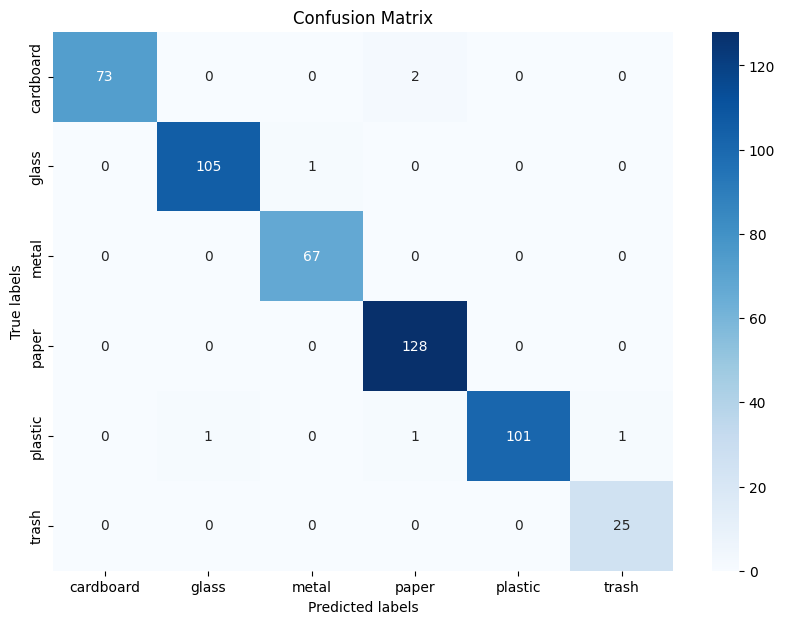

In [17]:
# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)  # Save in high definition

In [18]:
# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

Accuracy: 98.81%
Precision: 98.84%
Recall: 98.81%
F1 Score: 98.81%
Mean Absolute Error: 0.0238

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.97      0.99        75
       glass       0.99      0.99      0.99       106
       metal       0.99      1.00      0.99        67
       paper       0.98      1.00      0.99       128
     plastic       1.00      0.97      0.99       104
       trash       0.96      1.00      0.98        25

    accuracy                           0.99       505
   macro avg       0.99      0.99      0.99       505
weighted avg       0.99      0.99      0.99       505



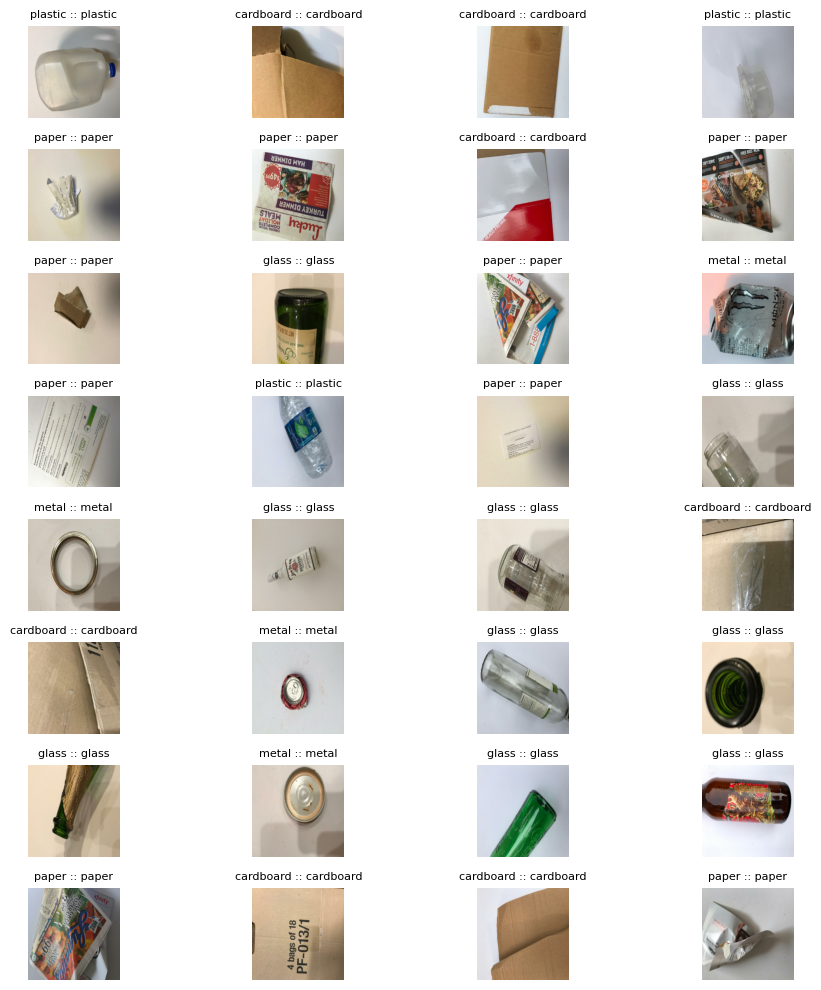

In [19]:
# ======================== Show Images with Predictions ========================
# Visualizing predictions against actual labels
plt.figure(figsize=(10, 10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}', fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.savefig('predictions_vs_actual_images.png', dpi=300)  # Save in high definition

In [20]:
# ======================== Save the Proposed Model ========================
# Save the trained model
eco_fri_nn.save('eco_fri_nn_model.keras')
print("Model Saved Successfully.")

Model Saved Successfully.


# **MobileNetV2 + Transfer Learning**

Dataset Sample:
                                               Image      Label
0  /content/drive/MyDrive/Datasets/dataset-resize...      paper
1  /content/drive/MyDrive/Datasets/dataset-resize...  cardboard
2  /content/drive/MyDrive/Datasets/dataset-resize...      glass
3  /content/drive/MyDrive/Datasets/dataset-resize...      paper
4  /content/drive/MyDrive/Datasets/dataset-resize...    plastic
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 546ms/step - accuracy: 0.3053 - loss: 4.0417 - val_accuracy: 0.5564 - val_loss: 3.3639
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.6122 - loss: 3.1984 - val_accuracy: 0.7050 - val_loss: 3.0730
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.6698 - loss: 3.0241 - val_accuracy: 0.7564 - val_loss: 2.8

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,243,604 (42.89 MB)

 Trainable params: 3,501,958 (13.36 MB)

 Non-trainable params: 737,728 (2.81 MB)

 Optimizer params: 7,003,918 (26.72 MB)

Training History:
    accuracy      loss  val_accuracy   val_loss
0   0.455984  3.604569      0.279208   5.937517
1   0.667161  3.033575      0.277228   6.315176
2   0.805638  2.651168      0.233663   7.728944
3   0.899110  2.386727      0.334653   7.460877
4   0.930762  2.236349      0.300990   8.027771
5   0.968348  2.098464      0.320792   7.867756
6   0.968843  2.012328      0.275248   9.230109
7   0.982690  1.923174      0.245545  10.409841
8   0.990603  1.840584      0.227723  11.291927
9   0.988625  1.780017      0.398020   7.165429
10  0.986152  1.720291      0.308911   9.944644
11  0.980712  1.672837      0.302970  10.311375
12  0.977250  1.635313      0.314851   9.475338
13  0.983680  1.551051      0.346535   8.527043
14  0.981701  1.497042      0.419802   7.405631
15  0.968348  1.468657      0.536634   4.118143
16  0.965875  1.426077      0.271287  11.211372
17  0.960930  1.394691      0.445545   6.612644
18  0.971316  1.288619      0.499010   7.082960
19  0.983680  1.213461

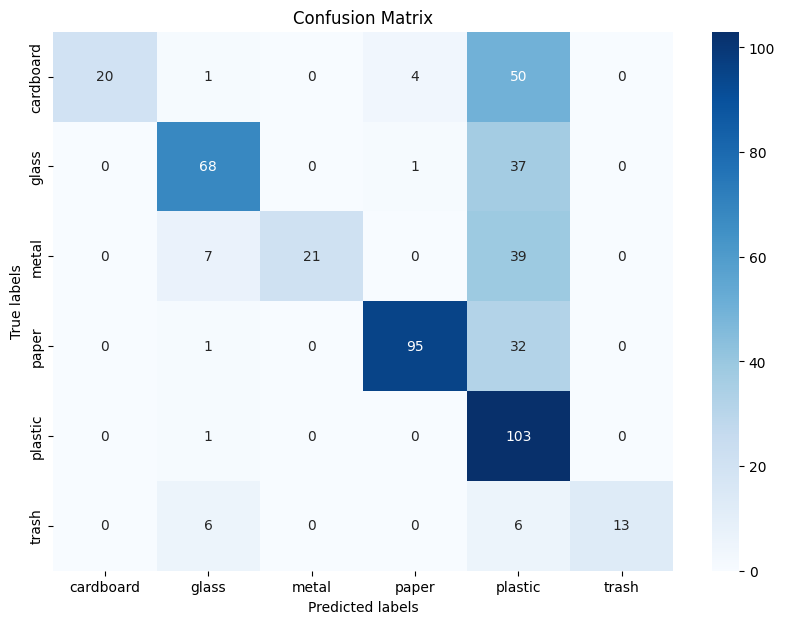

In [21]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build the MobileNetV2 + Transfer Learning Model ========================
# Building a model using MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_MobileNetV2 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_MobileNetV2_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tmobilenet = T_MobileNetV2.fit(train, epochs=30, validation_data=validation)
print('Fine Tuning Model')
# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_MobileNetV2 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_MobileNetV2_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tmobilenet = T_MobileNetV2.fit(train, epochs=30, validation_data=validation)

# Model Architecture
T_MobileNetV2.summary()

# Save Training History
hist_tmobilenet_df = pd.DataFrame(hist_tmobilenet.history)
print("Training History:")
print(hist_tmobilenet_df)

# ======================== Evaluate T_MobileNetV2 Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_MobileNetV2.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_MobileNetV2Transfer.png', dpi=300)  # Save in high definition

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **VGG19 + Transfer Learning**

Dataset Sample:
                                               Image      Label
0  /content/drive/MyDrive/Datasets/dataset-resize...      paper
1  /content/drive/MyDrive/Datasets/dataset-resize...  cardboard
2  /content/drive/MyDrive/Datasets/dataset-resize...      glass
3  /content/drive/MyDrive/Datasets/dataset-resize...      paper
4  /content/drive/MyDrive/Datasets/dataset-resize...    plastic
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.3272 - loss: 3.5038 - val_accuracy: 0.7050 - val_loss: 2.6351
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.6673 - loss: 2.5891 - val_accuracy: 0.8079 - val_loss: 2.4259
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.7589 - loss: 2.3421 - val_accuracy: 0.8614 - val_loss: 2.25

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,640,532 (242.77 MB)

 Trainable params: 21,211,974 (80.92 MB)

 Non-trainable params: 4,608 (18.00 KB)

 Optimizer params: 42,423,950 (161.83 MB)

Training History:
    accuracy      loss  val_accuracy   val_loss
0   0.250742  3.575015      0.253465  15.363806
1   0.325915  3.281963      0.257426   7.078700
2   0.374876  3.115136      0.338614   4.209873
3   0.393175  2.986314      0.324752   7.002422
4   0.436696  2.853115      0.172277   6.953913
5   0.432740  2.767211      0.201980   9.811283
6   0.464886  2.700741      0.142574  15.649119
7   0.481207  2.589451      0.150495   6.642292
8   0.477250  2.534675      0.148515   5.143042
9   0.500000  2.481175      0.142574  12.598098
10  0.486152  2.461025      0.148515  26.328552
11  0.518793  2.358729      0.148515   7.309409
12  0.559347  2.258480      0.148515   6.033108
13  0.551434  2.238194      0.148515   7.249979
14  0.555391  2.174783      0.148515   8.197478
15  0.559842  2.161937      0.148515  16.459324
16  0.574679  2.096654      0.510891   2.130194
17  0.614243  2.015271      0.221782   3.048572
18  0.621662  1.933742      0.170297   3.401230
19  0.642433  1.856840

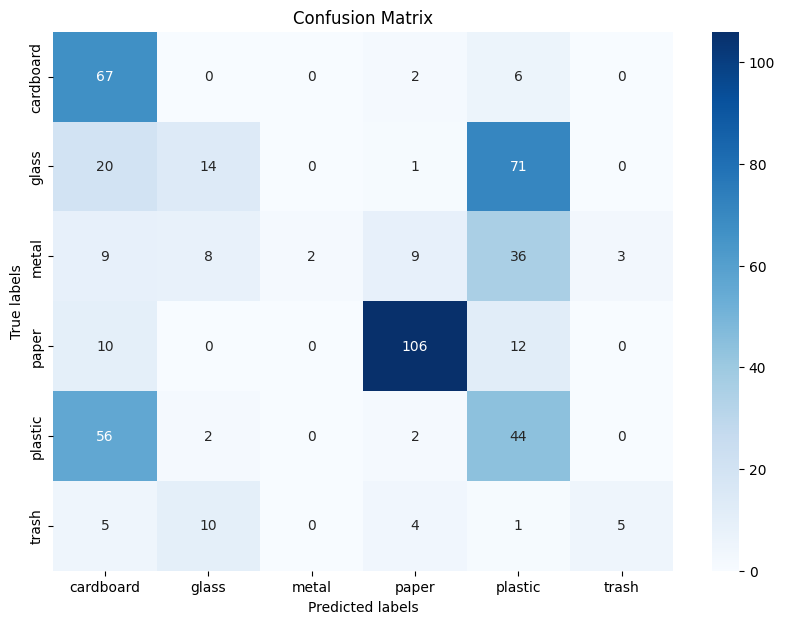

In [22]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build the VGG19 + Transfer Learning Model ========================
# Building a model using VGG19 base
base_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_VGG19 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_VGG19_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_VGG19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tvgg19 = T_VGG19.fit(train, epochs=30, validation_data=validation)
print('Fine Tuning The Model')
# Load base model
base_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_VGG19 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_VGG19_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_VGG19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tvgg19 = T_VGG19.fit(train, epochs=30, validation_data=validation)

# Model Architecture
T_VGG19.summary()

# Save Training History
hist_tvgg19_df = pd.DataFrame(hist_tvgg19.history)
print("Training History:")
print(hist_tvgg19_df)

# ======================== Evaluate VGG19 + Transfer Learning Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_VGG19.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_VGG19Transfer.png', dpi=300)  # Save in high definition

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **ResNet50 + Transfer Learning**

Dataset Sample:
                                               Image      Label
0  /content/drive/MyDrive/Datasets/dataset-resize...      paper
1  /content/drive/MyDrive/Datasets/dataset-resize...  cardboard
2  /content/drive/MyDrive/Datasets/dataset-resize...      glass
3  /content/drive/MyDrive/Datasets/dataset-resize...      paper
4  /content/drive/MyDrive/Datasets/dataset-resize...    plastic
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 822ms/step - accuracy: 0.3963 - loss: 4.0137 - val_accuracy: 0.7762 - val_loss: 3.0545
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.7748 - loss: 3.0260 - val_accuracy: 0.8614 - val_loss: 2.7982
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.8623 - loss: 2.7900 - val_accuracy: 0.9069 - val_loss: 2.6

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,786,324 (231.88 MB)

 Trainable params: 17,213,702 (65.67 MB)

 Non-trainable params: 9,145,216 (34.89 MB)

 Optimizer params: 34,427,406 (131.33 MB)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.596439  3.495113      0.708911  3.450177
1   0.857567  2.796352      0.790099  3.127571
2   0.936696  2.515991      0.861386  2.836013
3   0.967359  2.341941      0.940594  2.391355
4   0.969337  2.252608      0.958416  2.243878
5   0.982196  2.145870      0.952475  2.184048
6   0.989614  2.023431      0.950495  2.134544
7   0.991098  1.929254      0.972277  1.940981
8   0.994560  1.820092      0.978218  1.846115
9   0.992087  1.732958      0.944554  1.864819
10  0.981207  1.677709      0.966337  1.666162
11  0.989120  1.569571      0.962376  1.597224
12  0.980218  1.500226      0.972277  1.526022
13  0.982196  1.417771      0.964356  1.417868
14  0.985658  1.322813      0.970297  1.368593
15  0.983680  1.256936      0.958416  1.316840
16  0.980712  1.195825      0.978218  1.166935
17  0.988625  1.101995      0.970297  1.134747
18  0.992582  1.024836      0.982178  1.035725
19  0.992087  0.955398      0.972277  0.99

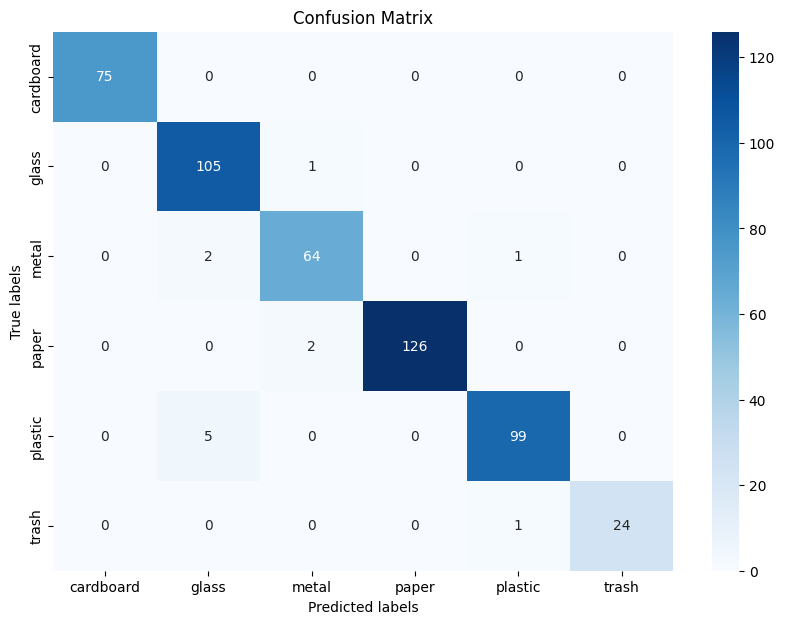

In [23]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build the ResNet50 + Transfer Learning Model ========================
# Building a model using ResNet50 base
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_ResNet50 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_ResNet50_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tresnet = T_ResNet50.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])
print('Fine Tuning The Model')
# Load base model
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_ResNet50 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_ResNet50_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tresnet = T_ResNet50.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

# Model Architecture
T_ResNet50.summary()

# Save Training History
hist_tresnet_df = pd.DataFrame(hist_tresnet.history)
print("Training History:")
print(hist_tresnet_df)

# ======================== Evaluate ResNet50 + Transfer Learning Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_ResNet50.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_ResNet50Transfer.png', dpi=300)  # Save in high definition

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **EfficientNetB0 + Transfer Learning**

Dataset Sample:
                                               Image      Label
0  /content/drive/MyDrive/Datasets/dataset-resize...      paper
1  /content/drive/MyDrive/Datasets/dataset-resize...  cardboard
2  /content/drive/MyDrive/Datasets/dataset-resize...      glass
3  /content/drive/MyDrive/Datasets/dataset-resize...      paper
4  /content/drive/MyDrive/Datasets/dataset-resize...    plastic
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 804ms/step - accuracy: 0.4501 - loss: 3.6193 - val_accuracy: 0.8634 - val_loss: 2.7838
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7778 - loss: 2.7471 - val_accuracy: 0.9109 - val_loss: 2.5117
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8626 - loss: 2.5480 - val_accuracy: 0.9406 - val_loss: 2.3

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,974,711 (49.49 MB)

 Trainable params: 3,471,718 (13.24 MB)

 Non-trainable params: 2,559,555 (9.76 MB)

 Optimizer params: 6,943,438 (26.49 MB)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.553412  3.372567      0.800000  2.793647
1   0.821958  2.657825      0.887129  2.475525
2   0.889219  2.449353      0.936634  2.308373
3   0.939169  2.269540      0.968317  2.164453
4   0.957468  2.169414      0.984158  2.061710
5   0.974777  2.054774      0.980198  1.992509
6   0.983680  1.975491      0.986139  1.939706
7   0.989120  1.904532      0.988119  1.867692
8   0.990603  1.826872      0.990099  1.795829
9   0.993571  1.753295      0.990099  1.727769
10  0.990603  1.699996      0.988119  1.676134
11  0.993076  1.622921      0.988119  1.603346
12  0.994065  1.555532      0.988119  1.535279
13  0.995054  1.489329      0.986139  1.489418
14  0.993076  1.431073      0.982178  1.435367
15  0.992582  1.365093      0.988119  1.367281
16  0.992582  1.307220      0.982178  1.312330
17  0.995549  1.239991      0.984158  1.258376
18  0.992087  1.187788      0.984158  1.193740
19  0.993571  1.123321      0.980198  1.12

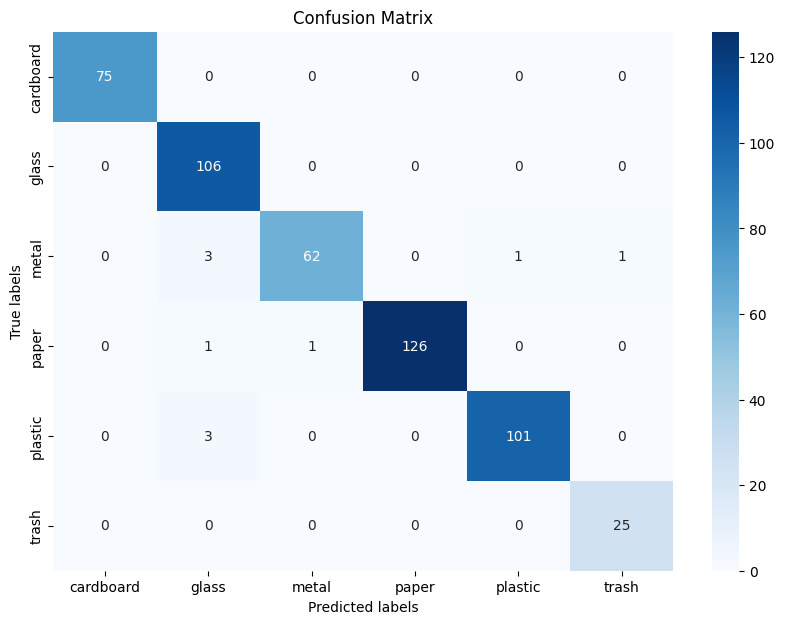

In [24]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build the EfficientNetB0 + Transfer Learning Model ========================
# Building a model using EfficientNetB0 base
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_EfficientNetB0 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_EfficientNetB0_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tefficientnet = T_EfficientNetB0.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])
print('Fine Tuning The Model')
# Load base model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_EfficientNetB0 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_EfficientNetB0_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tefficientnet = T_EfficientNetB0.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

# Model Architecture
T_EfficientNetB0.summary()

# Save Training History
hist_tefficientnet_df = pd.DataFrame(hist_tefficientnet.history)
print("Training History:")
print(hist_tefficientnet_df)

# ======================== Evaluate ResNet50 + Transfer Learning Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_EfficientNetB0.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_EfficientNetB0Transfer.png', dpi=300)  # Save in high definition

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **MobileNetV2**

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 325ms/step - accuracy: 0.2816 - loss: 1.8061 - val_accuracy: 0.5267 - val_loss: 1.3326
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5136 - loss: 1.2855 - val_accuracy: 0.5960 - val_loss: 1.1460
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5756 - loss: 1.1248 - val_accuracy: 0.6218 - val_loss: 1.0634
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.5967 - loss: 1.0549 - val_accuracy: 0.6257 - val_loss: 1.0205
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6127 - loss: 1.0135 - val_accuracy: 0.6436 - val_loss: 0.9736
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6376 - loss: 0.9605 - val_accuracy: 0.6634 - val_loss: 0.9314
Epoch 7/30
3

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,044 (8.70 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 15,374 (60.06 KB)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.370920  1.623697      0.526733  1.332640
1   0.530168  1.259432      0.596040  1.146034
2   0.586053  1.123587      0.621782  1.063398
3   0.614738  1.045348      0.625743  1.020497
4   0.634520  0.991265      0.643564  0.973554
5   0.652819  0.950119      0.663366  0.931409
6   0.666667  0.909840      0.669307  0.912202
7   0.673096  0.890854      0.710891  0.864223
8   0.698813  0.853385      0.716832  0.838918
9   0.713650  0.828377      0.748515  0.815113
10  0.720574  0.811809      0.734653  0.797383
11  0.724036  0.786716      0.760396  0.779318
12  0.740851  0.768987      0.756436  0.775394
13  0.740851  0.754507      0.760396  0.754783
14  0.744313  0.739973      0.776238  0.746198
15  0.755193  0.724123      0.766337  0.734789
16  0.758655  0.705927      0.778218  0.723966
17  0.756182  0.695638      0.782178  0.710450
18  0.767557  0.684973      0.784158  0.706044
19  0.769041  0.678503      0.786139  0.68

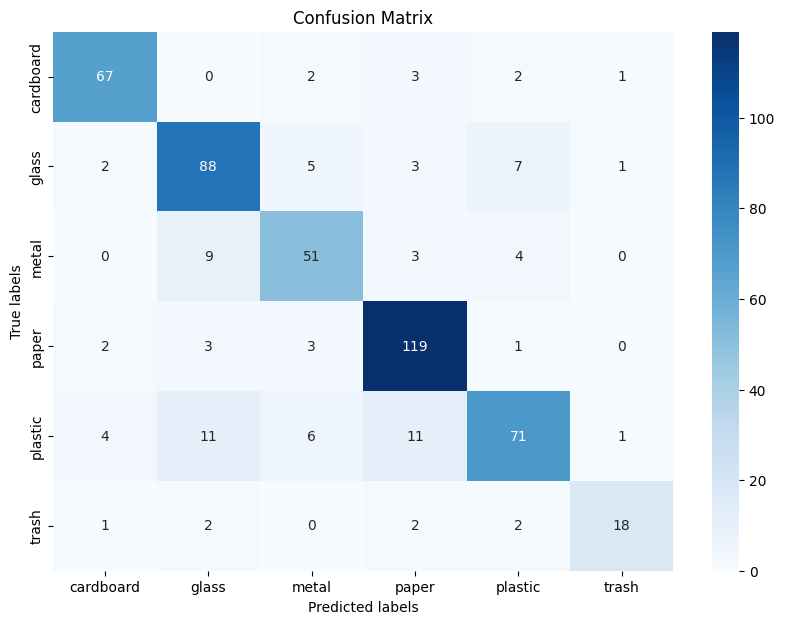

In [25]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

MNV2 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

MNV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_MobileNetV2_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_mobilenet = MNV2.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

MNV2.summary()

hist_mobilenet_df = pd.DataFrame(hist_mobilenet.history)
print("Training History:")
print(hist_mobilenet_df)

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = MNV2.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_MobileNetV2.png', dpi=300)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **VGG19**

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 524ms/step - accuracy: 0.1886 - loss: 5.1976 - val_accuracy: 0.3921 - val_loss: 2.8553
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 0.3882 - loss: 2.7019 - val_accuracy: 0.5010 - val_loss: 1.8857
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - accuracy: 0.5136 - loss: 1.9194 - val_accuracy: 0.5960 - val_loss: 1.4511
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - accuracy: 0.5838 - loss: 1.5128 - val_accuracy: 0.6614 - val_loss: 1.1892
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step - accuracy: 0.6196 - loss: 1.3186 - val_accuracy: 0.7010 - val_loss: 1.0207
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.6668 - loss: 1.1424 - val_accuracy: 0.7287 - val_loss: 0.9065
Epoch 7

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033,620 (76.42 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 6,158 (24.06 KB)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.250247  4.242911      0.392079  2.855286
1   0.412463  2.491974      0.500990  1.885668
2   0.526212  1.824687      0.596040  1.451137
3   0.587537  1.470060      0.661386  1.189152
4   0.632047  1.232846      0.700990  1.020677
5   0.678536  1.067101      0.728713  0.906509
6   0.706231  0.940967      0.762376  0.813921
7   0.730959  0.845686      0.768317  0.734153
8   0.748269  0.763054      0.796040  0.671720
9   0.763600  0.696510      0.807921  0.628853
10  0.789812  0.647122      0.823762  0.581649
11  0.797230  0.597280      0.831683  0.550721
12  0.807122  0.560340      0.835644  0.523702
13  0.823937  0.520993      0.843564  0.499790
14  0.832839  0.490488      0.855446  0.473863
15  0.845203  0.462704      0.865347  0.459359
16  0.850148  0.436643      0.863366  0.443075
17  0.863007  0.414328      0.867327  0.426500
18  0.868942  0.394279      0.871287  0.413092
19  0.870920  0.375292      0.877228  0.39

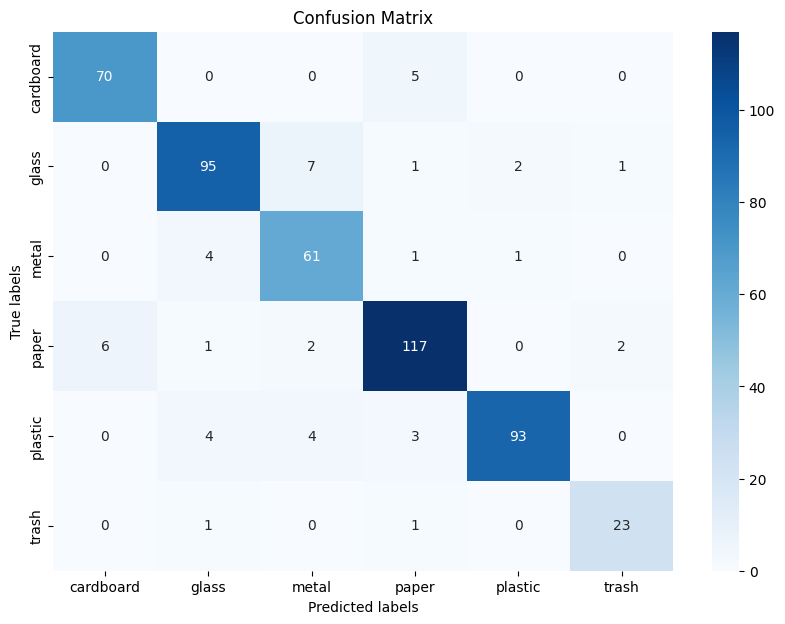

In [26]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

v19 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

v19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_VGG19_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_vgg19 = v19.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

v19.summary()

hist_vgg19_df = pd.DataFrame(hist_vgg19.history)
print("Training History:")
print(hist_vgg19_df)

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = v19.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_VGG19.png', dpi=300)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **ResNet50**

Dataset Sample:
                                               Image      Label
0  /content/drive/MyDrive/Datasets/dataset-resize...      paper
1  /content/drive/MyDrive/Datasets/dataset-resize...  cardboard
2  /content/drive/MyDrive/Datasets/dataset-resize...      glass
3  /content/drive/MyDrive/Datasets/dataset-resize...      paper
4  /content/drive/MyDrive/Datasets/dataset-resize...    plastic
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 472ms/step - accuracy: 0.3489 - loss: 1.7424 - val_accuracy: 0.6554 - val_loss: 0.8915
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.7064 - loss: 0.8176 - val_accuracy: 0.7802 - val_loss: 0.6515
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.7854 - loss: 0.6175 - val_accuracy: 0.8297 - val_loss: 0.5

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,624,596 (90.12 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 24,590 (96.06 KB)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.467359  1.415101      0.655446  0.891465
1   0.728981  0.774922      0.780198  0.651549
2   0.800198  0.604877      0.829703  0.542276
3   0.834322  0.518570      0.839604  0.480309
4   0.850643  0.457286      0.861386  0.433111
5   0.866469  0.411407      0.877228  0.400449
6   0.880316  0.374990      0.889109  0.375823
7   0.893175  0.350321      0.885149  0.349473
8   0.908506  0.316787      0.906931  0.325595
9   0.919387  0.294892      0.916832  0.306664
10  0.929772  0.278643      0.916832  0.296499
11  0.935213  0.260570      0.918812  0.280741
12  0.942631  0.245288      0.930693  0.268497
13  0.947082  0.229428      0.934653  0.261308
14  0.948071  0.220345      0.938614  0.244836
15  0.955984  0.207256      0.936634  0.239215
16  0.960435  0.193703      0.940594  0.229551
17  0.961919  0.183403      0.950495  0.223599
18  0.966864  0.174695      0.942574  0.217159
19  0.967854  0.167784      0.950495  0.20

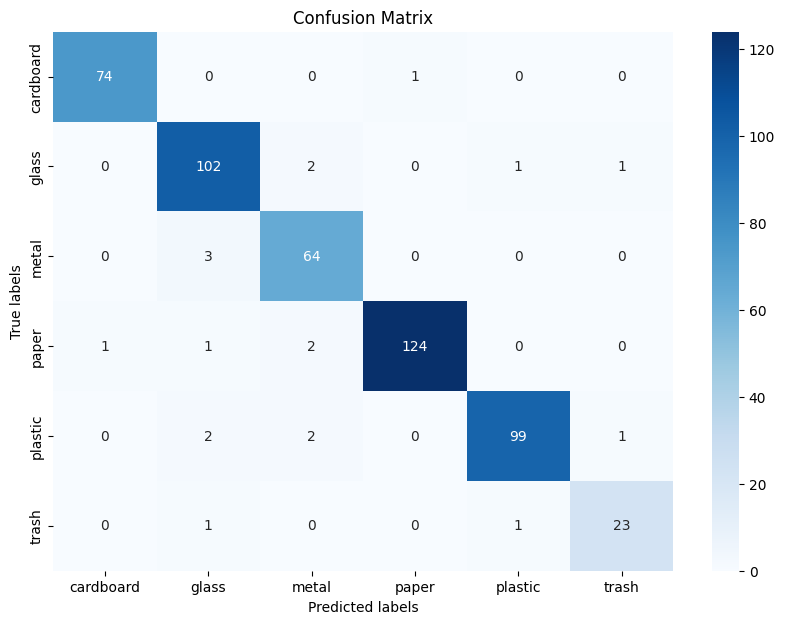

In [27]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


print("Dataset Sample:")
print(dataframe.head())

# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

RN50 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

RN50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_RN50_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_resnet = RN50.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

RN50.summary()

hist_resnet_df = pd.DataFrame(hist_resnet.history)
print("Training History:")
print(hist_resnet_df)

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = RN50.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_ResNet50.png', dpi=300)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **EfficientNetB0**

Dataset Sample:
                                               Image      Label
0  /content/drive/MyDrive/Datasets/dataset-resize...      paper
1  /content/drive/MyDrive/Datasets/dataset-resize...  cardboard
2  /content/drive/MyDrive/Datasets/dataset-resize...      glass
3  /content/drive/MyDrive/Datasets/dataset-resize...      paper
4  /content/drive/MyDrive/Datasets/dataset-resize...    plastic
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 637ms/step - accuracy: 0.3495 - loss: 1.6088 - val_accuracy: 0.7208 - val_loss: 0.9793
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.7213 - loss: 0.9309 - val_accuracy: 0.8079 - val_loss: 0.6924
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.7839 - loss: 0.7002 - val_accuracy: 0.8475 - val_loss: 0.5

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,072,631 (15.54 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 15,374 (60.06 KB)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.491098  1.404954      0.720792  0.979320
1   0.738872  0.867918      0.807921  0.692392
2   0.801187  0.675332      0.847525  0.570190
3   0.830366  0.571001      0.859406  0.497514
4   0.852621  0.506264      0.869307  0.448204
5   0.865480  0.459240      0.875248  0.411474
6   0.867458  0.426012      0.883168  0.383806
7   0.886746  0.392328      0.893069  0.359990
8   0.892681  0.370807      0.895050  0.339507
9   0.899110  0.348734      0.899010  0.321823
10  0.904550  0.332951      0.904950  0.308327
11  0.907023  0.319474      0.910891  0.293650
12  0.914936  0.300724      0.916832  0.281349
13  0.918892  0.292153      0.918812  0.270161
14  0.923343  0.280794      0.924752  0.260015
15  0.920870  0.268555      0.928713  0.251642
16  0.925816  0.261834      0.932673  0.241347
17  0.931256  0.249111      0.940594  0.233167
18  0.936696  0.237495      0.940594  0.225678
19  0.934224  0.232994      0.942574  0.21

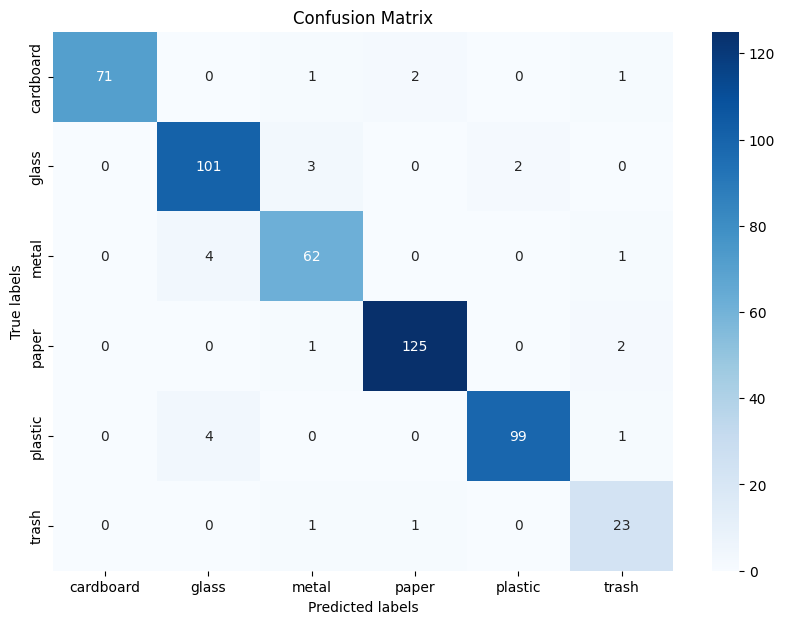

In [28]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error
import glob
import warnings

warnings.filterwarnings('ignore')


print("Dataset Sample:")
print(dataframe.head())

# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)


# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

ENB0 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

ENB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_ENB0_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_efficientnet = ENB0.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

ENB0.summary()

hist_efficientnet_df = pd.DataFrame(hist_efficientnet.history)
print("Training History:")
print(hist_efficientnet_df)

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = ENB0.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_EfficientNetB0.png', dpi=300)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

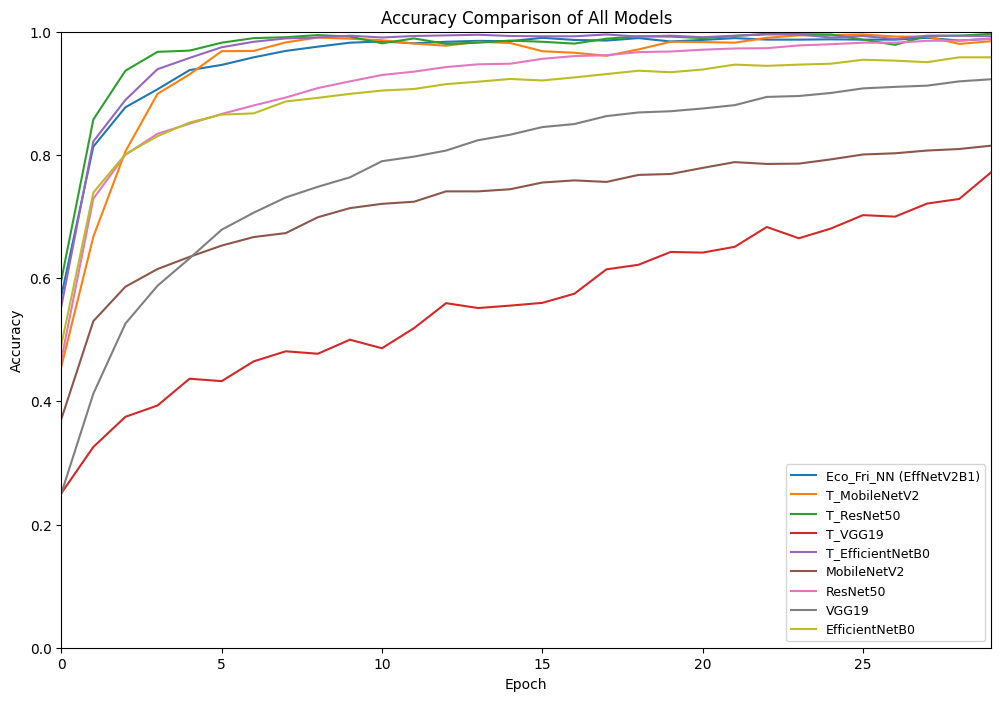

In [29]:
# Accuracy values
acc_eco_fri_nn = hist_eco_fri_nn_df['accuracy']
acc_tmobilenet = hist_tmobilenet_df['accuracy']
acc_tresnet50 = hist_tresnet_df['accuracy']
acc_tvgg19 = hist_tvgg19_df['accuracy']
acc_tefficientb0 = hist_tefficientnet_df['accuracy']
acc_mobilenet = hist_mobilenet_df['accuracy']
acc_resnet50 = hist_resnet_df['accuracy']
acc_vgg19 = hist_vgg19_df['accuracy']
acc_efficientb0 = hist_efficientnet_df['accuracy']

plt.figure(figsize=(12, 8))

plt.plot(acc_eco_fri_nn, label='Eco_Fri_NN (EffNetV2B1)')
plt.plot(acc_tmobilenet, label='T_MobileNetV2')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_tefficientb0, label='T_EfficientNetB0')
plt.plot(acc_mobilenet, label='MobileNetV2')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')
plt.plot(acc_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of All Models')
plt.legend(loc='lower right', fontsize=9)
plt.ylim(0, 1)
plt.gca().margins(x=0)

plt.savefig('Accuracy.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

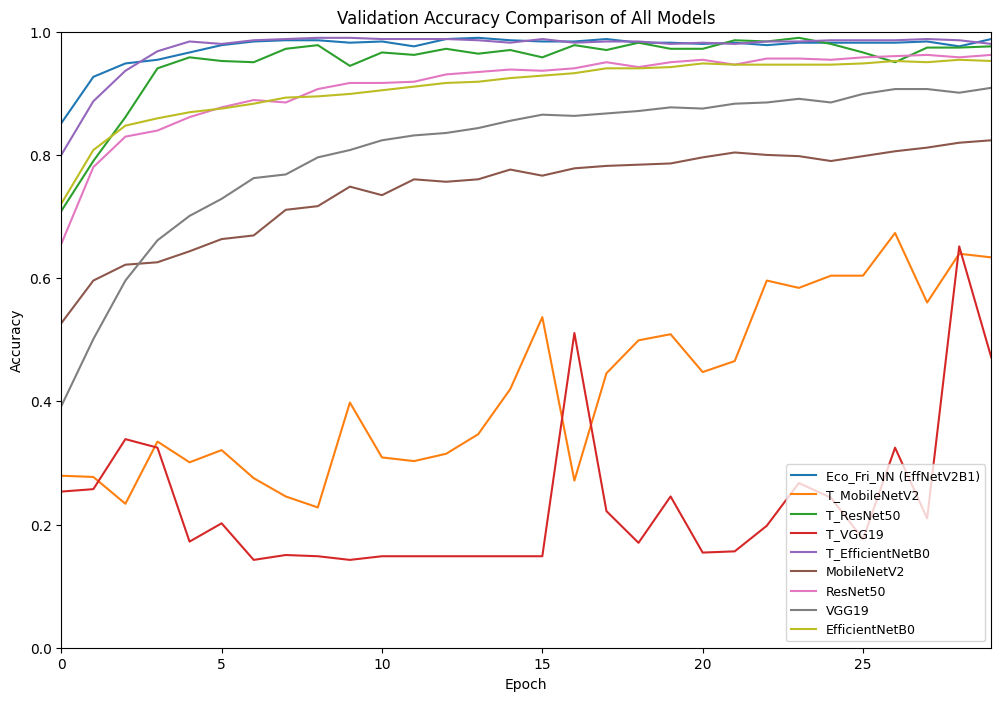

In [30]:
# Validation Accuracy values
val_acc_eco_fri_nn = hist_eco_fri_nn_df['val_accuracy']
val_acc_tmobilenet = hist_tmobilenet_df['val_accuracy']
val_acc_tresnet50 = hist_tresnet_df['val_accuracy']
val_acc_tvgg19 = hist_tvgg19_df['val_accuracy']
val_acc_tefficientb0 = hist_tefficientnet_df['val_accuracy']
val_acc_mobilenet = hist_mobilenet_df['val_accuracy']
val_acc_resnet50 = hist_resnet_df['val_accuracy']
val_acc_vgg19 = hist_vgg19_df['val_accuracy']
val_acc_efficientb0 = hist_efficientnet_df['val_accuracy']

plt.figure(figsize=(12, 8))

plt.plot(val_acc_eco_fri_nn, label='Eco_Fri_NN (EffNetV2B1)')
plt.plot(val_acc_tmobilenet, label='T_MobileNetV2')
plt.plot(val_acc_tresnet50, label='T_ResNet50')
plt.plot(val_acc_tvgg19, label='T_VGG19')
plt.plot(val_acc_tefficientb0, label='T_EfficientNetB0')
plt.plot(val_acc_mobilenet, label='MobileNetV2')
plt.plot(val_acc_resnet50, label='ResNet50')
plt.plot(val_acc_vgg19, label='VGG19')
plt.plot(val_acc_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison of All Models')
plt.legend(loc='lower right', fontsize=9)
plt.ylim(0, 1)
plt.gca().margins(x=0)

plt.savefig('Validation_Accuracy.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


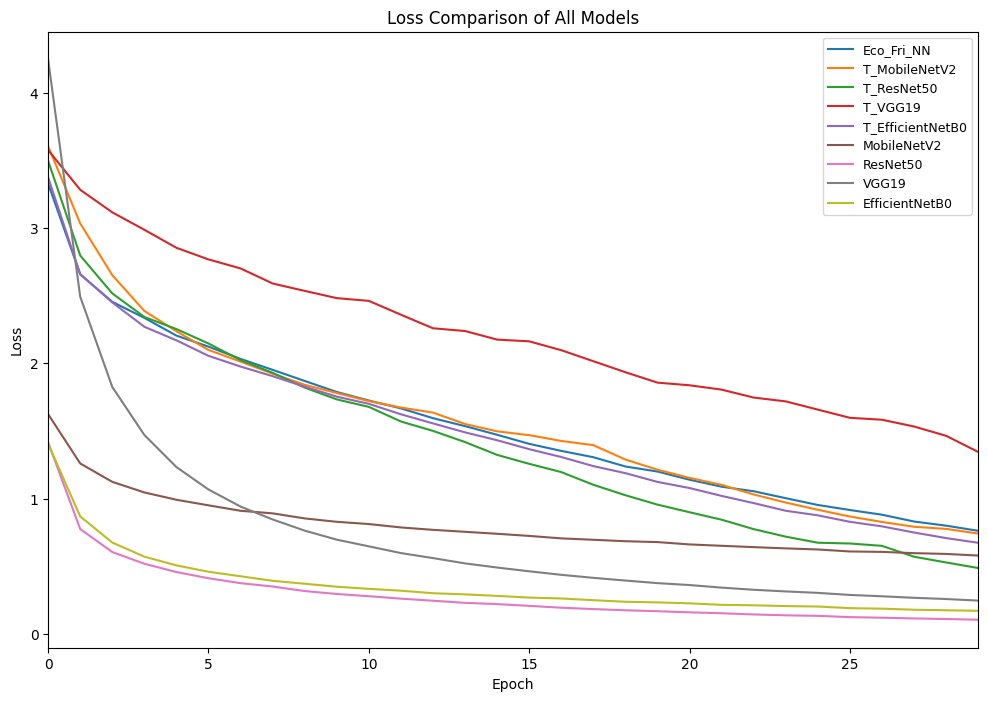

In [31]:
# Training Loss values
loss_eco_fri_nn = hist_eco_fri_nn_df['loss']
loss_tmobilenet = hist_tmobilenet_df['loss']
loss_tresnet50 = hist_tresnet_df['loss']
loss_tvgg19 = hist_tvgg19_df['loss']
loss_tefficientb0 = hist_tefficientnet_df['loss']
loss_mobilenet = hist_mobilenet_df['loss']
loss_resnet50 = hist_resnet_df['loss']
loss_vgg19 = hist_vgg19_df['loss']
loss_efficientb0 = hist_efficientnet_df['loss']

plt.figure(figsize=(12, 8))

plt.plot(loss_eco_fri_nn, label='Eco_Fri_NN')
plt.plot(loss_tmobilenet, label='T_MobileNetV2')
plt.plot(loss_tresnet50, label='T_ResNet50')
plt.plot(loss_tvgg19, label='T_VGG19')
plt.plot(loss_tefficientb0, label='T_EfficientNetB0')
plt.plot(loss_mobilenet, label='MobileNetV2')
plt.plot(loss_resnet50, label='ResNet50')
plt.plot(loss_vgg19, label='VGG19')
plt.plot(loss_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison of All Models')
plt.legend(loc='upper right', fontsize=9)
plt.gca().margins(x=0)

plt.savefig('Loss.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


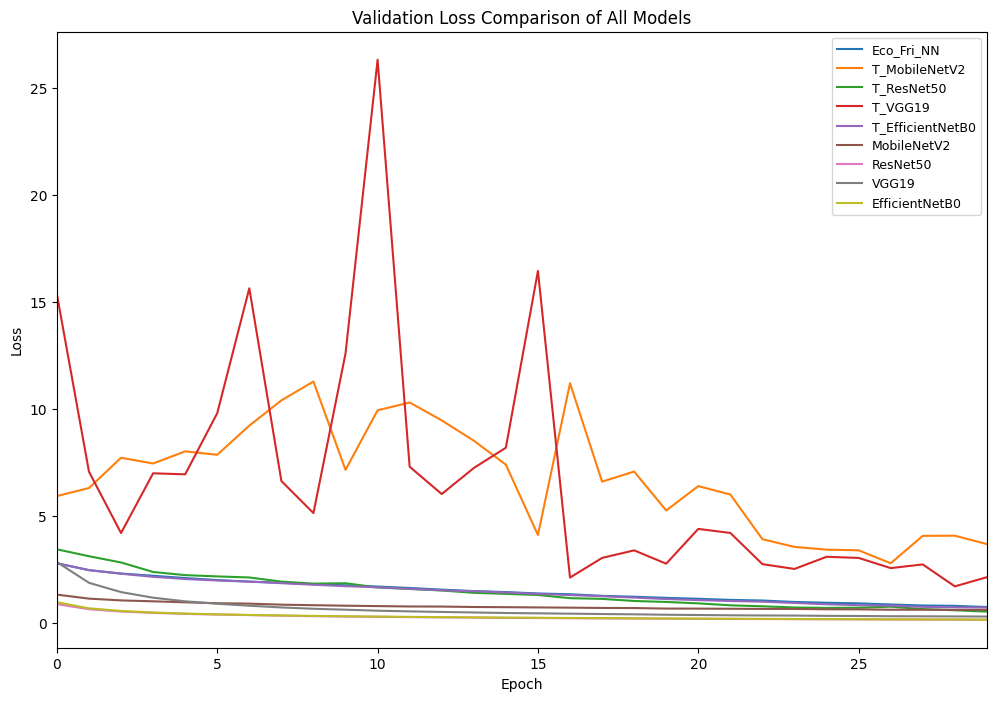

In [32]:
# Validation Loss values
val_loss_eco_fri_nn = hist_eco_fri_nn_df['val_loss']
val_loss_tmobilenet = hist_tmobilenet_df['val_loss']
val_loss_tresnet50 = hist_tresnet_df['val_loss']
val_loss_tvgg19 = hist_tvgg19_df['val_loss']
val_loss_tefficientb0 = hist_tefficientnet_df['val_loss']
val_loss_mobilenet = hist_mobilenet_df['val_loss']
val_loss_resnet50 = hist_resnet_df['val_loss']
val_loss_vgg19 = hist_vgg19_df['val_loss']
val_loss_efficientb0 = hist_efficientnet_df['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(val_loss_eco_fri_nn, label='Eco_Fri_NN')
plt.plot(val_loss_tmobilenet, label='T_MobileNetV2')
plt.plot(val_loss_tresnet50, label='T_ResNet50')
plt.plot(val_loss_tvgg19, label='T_VGG19')
plt.plot(val_loss_tefficientb0, label='T_EfficientNetB0')
plt.plot(val_loss_mobilenet, label='MobileNetV2')
plt.plot(val_loss_resnet50, label='ResNet50')
plt.plot(val_loss_vgg19, label='VGG19')
plt.plot(val_loss_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison of All Models')
plt.legend(loc='upper right', fontsize=9)
plt.gca().margins(x=0)

plt.savefig('Validation_Loss.png', format='png', dpi=600, bbox_inches='tight')
plt.show()
